In [1]:
import pandas as pd
import numpy as np
from numba import jit, prange
from time import time, sleep
import matplotlib.pyplot as plt

In [2]:
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

In [3]:
print(movies.shape)
movies.head()

(62423, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
print(ratings.shape)
ratings.head()

(25000095, 4)


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


#### Reindexing movieId and userId

In [5]:
myMovieId = np.empty((max(ratings.movieId) + 1), dtype = int)
myUserId = np.empty((max(ratings.userId) + 1), dtype = int)

j = 0
for i in sorted(ratings.movieId.unique()):
    myMovieId[i] = int(j)
    j += 1
    
print(myMovieId[-1])


j = 0
for i in sorted(ratings.userId.unique()):
    myUserId[i] = int(j)
    j += 1
    
print(myUserId[-1])

59046
162540


In [6]:
# Sort the ratings dataframe by userId and moviesId 
# to get the ratings and indices for users and movies sorted
ratings_ordered_by_users = ratings.sort_values('userId')
ratings_ordered_by_movies = ratings.sort_values('movieId')

# Get the ratings and indices
all_users_ratings = np.array(ratings_ordered_by_users.rating)
all_users_movieIds = np.array(ratings_ordered_by_users.movieId)
user_indices = np.append([0], np.array(ratings_ordered_by_users['userId'].value_counts(sort=False)).cumsum())

all_movies_ratings = np.array(ratings_ordered_by_movies.rating)
all_movies_userIds = np.array(ratings_ordered_by_movies.userId)
movie_indices = np.append([0], np.array(ratings_ordered_by_movies['movieId'].value_counts(sort=False)).cumsum())

In [7]:
@jit(nopython=True)
def index_mapping(Ids, myIdMap):
    for i in prange(len(Ids)):
        Ids[i] = myIdMap[Ids[i]]
        
index_mapping(all_movies_userIds, myUserId)
index_mapping(all_users_movieIds, myMovieId)

### Plotting One of "The Hobbit" Movies and Jumanji's Rating Count

In [8]:
movies[movies['title'].str.contains('Hobbit')]

,movieId,title,genres
18952,98809,"Hobbit: An Unexpected Journey, The (2012)",Adventure|Fantasy|IMAX
20603,106489,"Hobbit: The Desolation of Smaug, The (2013)",Adventure|Fantasy|IMAX
23594,118696,The Hobbit: The Battle of the Five Armies (2014),Adventure|Fantasy


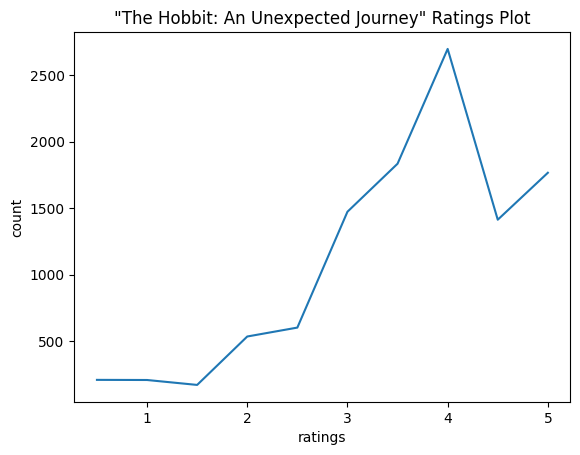

In [9]:
hobbit_unexpected = ratings[ratings['movieId'] == 98809]
hobbit_unexpected_rate = hobbit_unexpected.groupby(['rating'])['rating'].count()
hobbit_unexpected_rate.head()

plt.plot(hobbit_unexpected_rate);
plt.title('"The Hobbit: An Unexpected Journey" Ratings Plot');
plt.xlabel("ratings");
plt.ylabel("count");

In [10]:
jumanji = ratings[ratings['movieId'] == 2]
jumanji.head()

,userId,movieId,rating,timestamp
1459,9,2,5.0,859383142
1715,12,2,2.0,968257492
3203,19,2,3.5,1445286613
3661,20,2,2.5,1062004110
5051,35,2,3.0,1511296015


In [11]:
jumanji_rate = jumanji.groupby(['rating'])['rating'].count()
jumanji_rate.head()

rating
0.5     259
1.0     706
1.5     496
2.0    2240
2.5    1701
Name: rating, dtype: int64

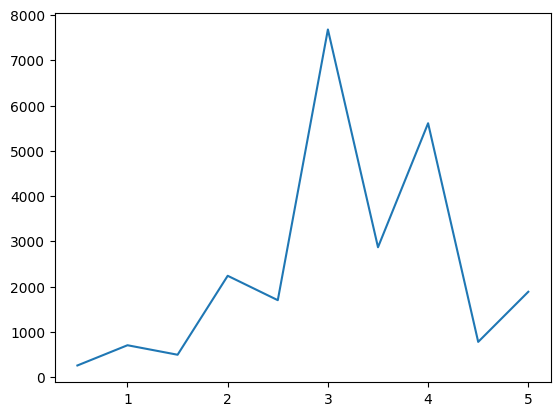

In [12]:
plt.plot(jumanji_rate)

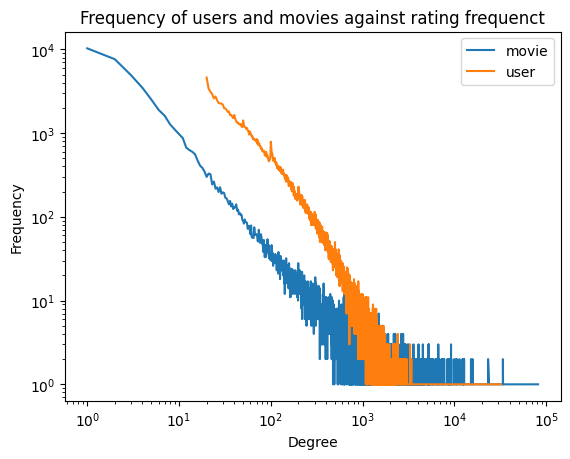

In [13]:
user_count = np.sort(ratings['userId'].value_counts())
rating_u_count = np.unique(user_count, return_counts=True)
movie_count = np.sort(ratings['movieId'].value_counts())
rating_i_count = np.unique(movie_count, return_counts=True)

plt.loglog(rating_i_count[0], rating_i_count[1], label="movie");
plt.loglog(rating_u_count[0], rating_u_count[1], label="user");
plt.xlabel('Degree');
plt.ylabel('Frequency');
plt.title("Frequency of users and movies against rating frequenct");
plt.legend();

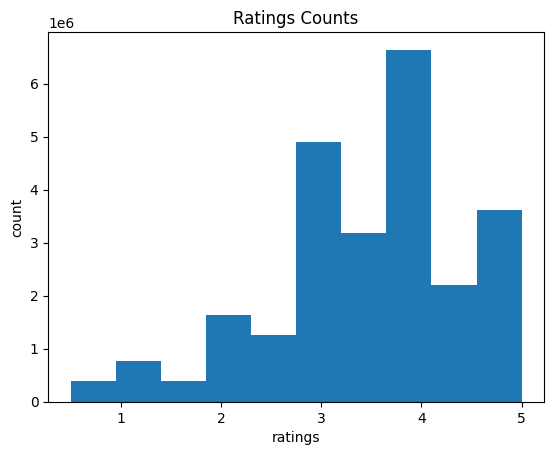

In [95]:
plt.hist(ratings.rating, bins=len(ratings.rating.unique()));
plt.xlabel('ratings');
plt.ylabel('count');
plt.title("Ratings Counts");

### Alternating Least Squares (ALS), biases only

In [21]:
@jit(nopython=True)
def bias_update(l, alpha, bias_to_update, other_bias, indices, ids, ratings):
    
    for i in prange(1, len(indices)):
        
        n = ids[indices[i-1] : indices[i]]
        rating = ratings[indices[i-1] : indices[i]]
        
        # update user bias
        bias_to_update[i-1] = (l * (rating - other_bias[n]).sum()) / (len(n)*l + alpha)
    
    return bias_to_update

@jit(nopython=True)
def calc_loss_bias_only(user_indices, all_users_movieIds, all_users_ratings, bm, bn, N, l, alpha):
    
    diff_vals = 0
    
    for i in prange(1, len(user_indices)):
        n = all_users_movieIds[user_indices[i-1] : user_indices[i]]
        rating = all_users_ratings[user_indices[i-1] : user_indices[i]]
        
        diff_vals += np.sum((rating - bm[i-1] - bn[n])**2)
            
    loss_value = (-(l/2) * diff_vals  
                  - (alpha/2)* bm.sum()**2 
                  - (alpha/2)* bn.sum()**2) ## loss
    
    rmse_value = np.sqrt(diff_vals / N) ## rmse
    
    return loss_value, rmse_value

In [24]:
N = len(ratings)
# Initialize user and item bias
bm = np.zeros(myUserId[-1] + 1)
bn = np.zeros(myMovieId[-1] + 1)
# Define the regularizers
l = 0.01
tau = 0.1
alpha = 0.01

rmse_als_bias = []
loss_als_bias = []


for z in range(20):

    bm = bias_update(l, alpha, bm, bn, user_indices, all_users_movieIds, all_users_ratings)
    bn = bias_update(l, alpha, bn, bm, movie_indices, all_movies_userIds, all_movies_ratings)
    print("iteration:", z+1)
    
    loss_val, rmse_val = calc_loss_bias_only(user_indices, 
                                             all_users_movieIds, 
                                             all_users_ratings, 
                                             bm, bn, N, l, alpha)
    loss_als_bias.append(loss_val)
    rmse_als_bias.append(rmse_val)
    
    print("RMSE:", rmse_als_bias[-1], "\t", "Loss:", loss_als_bias[-1])

iteration: 1
RMSE: 0.8656620302409083 	 Loss: -1725802705.362071
iteration: 2
RMSE: 0.8516225182478733 	 Loss: -1663233573.562043
iteration: 3
RMSE: 0.851088788870222 	 Loss: -1635174773.9632607
iteration: 4
RMSE: 0.8510511178964042 	 Loss: -1613200982.6039546
iteration: 5
RMSE: 0.8510329237515321 	 Loss: -1592332687.3117173
iteration: 6
RMSE: 0.851019171927056 	 Loss: -1571787480.5195367
iteration: 7
RMSE: 0.8510082325557117 	 Loss: -1551490958.8380032
iteration: 8
RMSE: 0.850998900987855 	 Loss: -1531461146.0736687
iteration: 9
RMSE: 0.8509904844962805 	 Loss: -1511713920.270305
iteration: 10
RMSE: 0.8509826401180418 	 Loss: -1492255805.1757581
iteration: 11
RMSE: 0.8509752055591465 	 Loss: -1473087559.2101808
iteration: 12
RMSE: 0.8509681036989919 	 Loss: -1454207089.9967089
iteration: 13
RMSE: 0.8509612964059883 	 Loss: -1435611006.2411742
iteration: 14
RMSE: 0.8509547632940406 	 Loss: -1417295359.2413645
iteration: 15
RMSE: 0.8509484920912466 	 Loss: -1399255984.369197
iteration: 

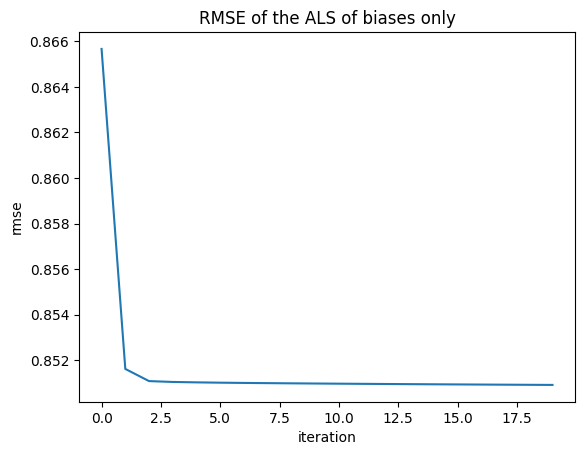

In [25]:
plt.plot(rmse_als_bias, label='RMSE');
plt.title("RMSE of the ALS of biases only");
plt.xlabel("iteration");
plt.ylabel("rmse");

### User and Item Update

In [27]:
@jit(nopython=True)
def trait_vector_update(l, tau, alpha, k, trait_to_update, other_trait_vector, bias_to_update, other_bias, 
                        indices, Ids, all_ratings):
    
    for i in prange(1, len(indices)):
        
        n = Ids[indices[i-1] : indices[i]]
        rating = all_ratings[indices[i-1] : indices[i]]
        
        # update user bias
        bias_to_update[i-1] = (l * (rating - (trait_to_update[i-1] * other_trait_vector[n]).sum(axis=1) - other_bias[n]).sum()) / (len(n)*l + alpha)
        
        # update user trait vector u
        trait_vec_sum = other_trait_vector[n].T @ other_trait_vector[n]
        rv = ((rating - bias_to_update[i-1] - other_bias[n]).reshape(len(other_trait_vector[n]), 1) * other_trait_vector[n]).sum(axis=0)

        first_mat = np.linalg.inv(l * trait_vec_sum + tau * np.eye(k))
        second_mat = l * rv
        
        # update user trait vector u
        trait_to_update[i-1] = (first_mat @ second_mat.reshape(k, 1)).reshape(1, k)
    
    return trait_to_update


@jit(nopython=True)
def calc_loss(user_indices, all_users_movieIds, all_users_ratings, u, v, bm, bn, N, l, tau, alpha):
    
    diff_vals = 0
    
    for i in prange(1, len(user_indices)):
        n = all_users_movieIds[user_indices[i-1] : user_indices[i]]
        rating = all_users_ratings[user_indices[i-1] : user_indices[i]]
        
        diff_vals += np.sum((rating - (u[i-1]* v[n]).sum(axis=1) - bm[i-1] - bn[n])**2)
            
    loss_value = (-(l/2) * diff_vals - (tau / 2) * (u * u).sum() 
                  - (tau / 2) * (v * v).sum() - (alpha/2)* bm.sum()**2 
                  - (alpha/2)* bn.sum()**2) ## loss
    rmse_value = np.sqrt(diff_vals / N) ## rmse
    
    return loss_value, rmse_value

In [33]:
N = len(ratings)
mid_rank = (min(ratings.rating) + max(ratings.rating)) / 2

# Initialize the regularizers and hyperparameters
k = 2
l = 0.01
tau = 0.1
alpha = 0.01

# User and Item matrices
v = np.random.normal(0, mid_rank / np.sqrt(N), (myMovieId[-1] + 1, k))
u = np.random.normal(0, mid_rank / np.sqrt(N), (myUserId[-1] + 1, k))
# Initialize user and item bias
bm = np.zeros(len(u))
bn = np.zeros(len(v))


rmse = []
loss = []

for z in range(20):

    u = trait_vector_update(l, tau, alpha, k, u, v, bm, bn, user_indices, all_users_movieIds, all_users_ratings)
    v = trait_vector_update(l, tau, alpha, k, v, u, bn, bm, movie_indices, all_movies_userIds, all_movies_ratings)
    print("iteration:", z+1)
    
    loss_val, rmse_val = calc_loss(user_indices, all_users_movieIds, all_users_ratings, u, v, bm, bn, N, l, tau, alpha)
    loss.append(loss_val)
    rmse.append(rmse_val)
    
    print("RMSE:", rmse[-1], "\t", "Loss:", loss[-1])

iteration: 1
RMSE: 0.8656505457873602 	 Loss: -1725802703.9918063
iteration: 2
RMSE: 0.8356773110618388 	 Loss: -1663226301.932445
iteration: 3
RMSE: 0.8197135381900408 	 Loss: -1625892383.5207553
iteration: 4
RMSE: 0.8104034481578551 	 Loss: -1589973306.705226
iteration: 5
RMSE: 0.8044383740361164 	 Loss: -1555157092.5363064
iteration: 6
RMSE: 0.8017957942709727 	 Loss: -1523535038.3880696
iteration: 7
RMSE: 0.8005839418334069 	 Loss: -1494756031.097421
iteration: 8
RMSE: 0.799952042638964 	 Loss: -1468091081.904988
iteration: 9
RMSE: 0.7995832140017511 	 Loss: -1443056471.2383008
iteration: 10
RMSE: 0.799347536966501 	 Loss: -1419304248.2176065
iteration: 11
RMSE: 0.7991856226362046 	 Loss: -1396585817.6527395
iteration: 12
RMSE: 0.7990677720030267 	 Loss: -1374724375.2352886
iteration: 13
RMSE: 0.7989779919404029 	 Loss: -1353593731.1259413
iteration: 14
RMSE: 0.7989071073668913 	 Loss: -1333103173.2498074
iteration: 15
RMSE: 0.7988495530999116 	 Loss: -1313186758.0379322
iteration:

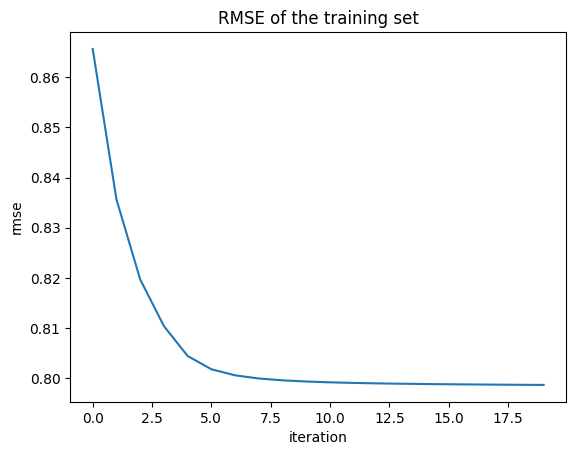

In [34]:
plt.plot(rmse, label='RMSE');
plt.title("RMSE of the training set");
plt.xlabel("iteration");
plt.ylabel("rmse");

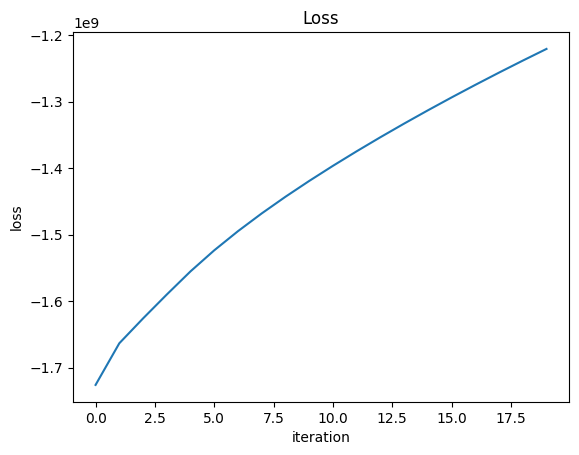

In [35]:
plt.plot(loss, label='Loss');
plt.title("Loss");
plt.xlabel("iteration");
plt.ylabel("loss");

### 2D Embeddings of the Item Trait Vectors

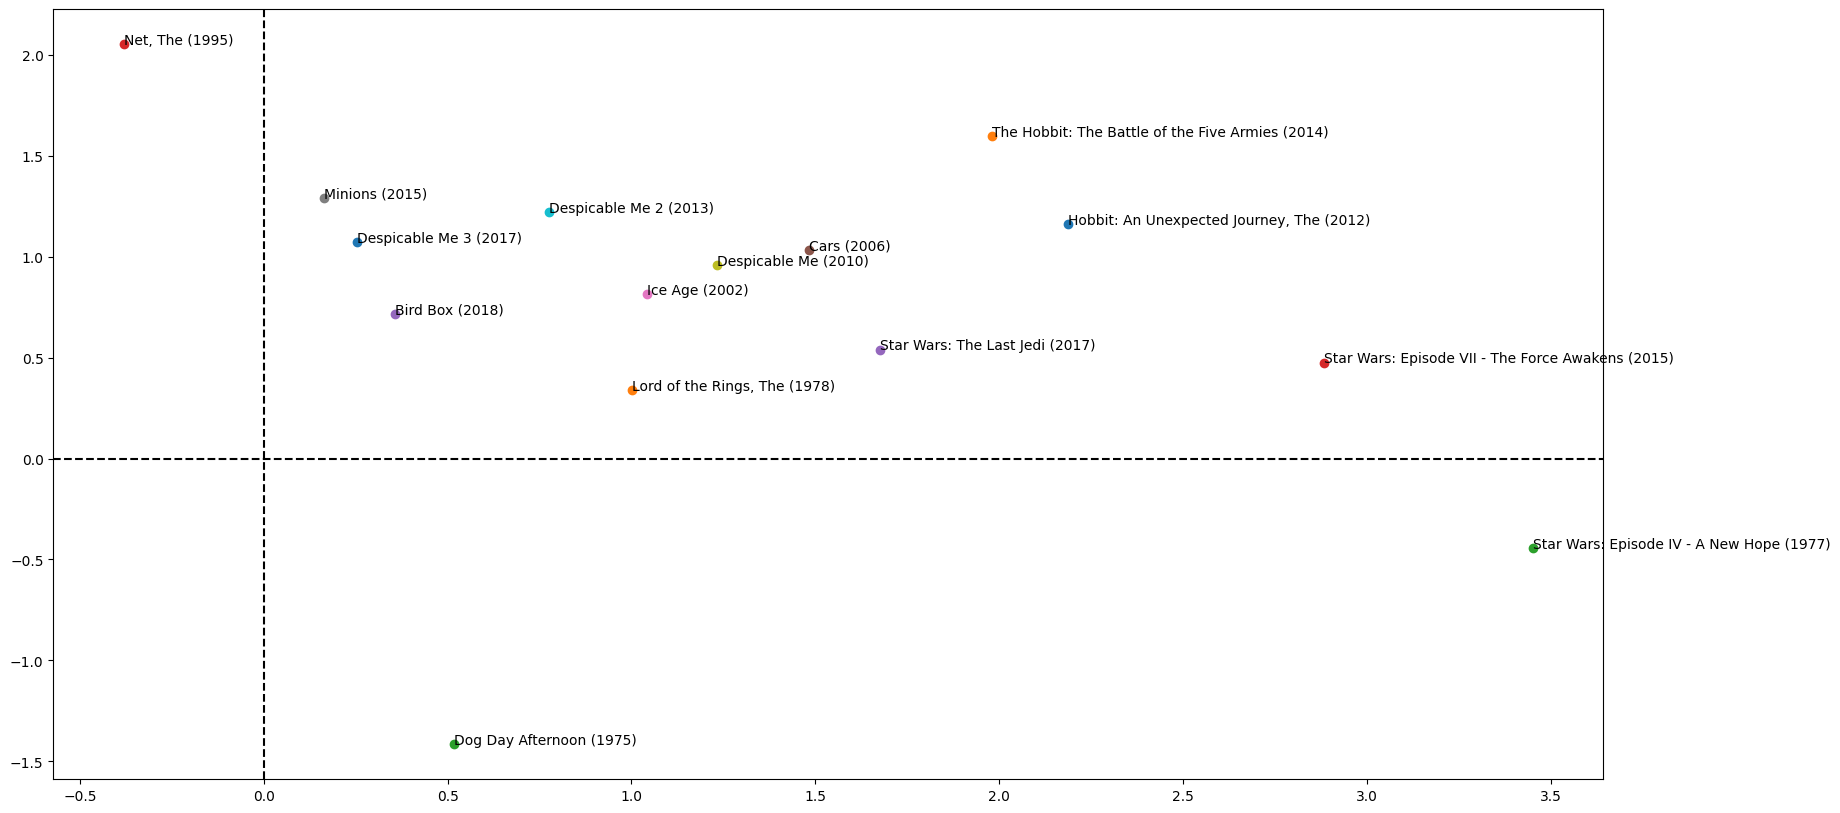

In [36]:
selected_indices = [myMovieId[98809], myMovieId[118696],
                    myMovieId[260], myMovieId[122886],
                    myMovieId[179819], myMovieId[45517],
                    myMovieId[5218], myMovieId[135887], myMovieId[79091],
                    myMovieId[103335], myMovieId[172547], myMovieId[2116],
                    myMovieId[3362], myMovieId[185], myMovieId[194951]]
movie_names = []

for index in selected_indices:
    movie_names.append(movies[movies['movieId'] == np.where(myMovieId == index)[0][0]].title.item());
    
fig, ax = plt.subplots(figsize=(20, 10))
    
for i in range(len(v[selected_indices])):
    ax.scatter(v[selected_indices][i][0], v[selected_indices][i][1], label=movie_names[i]);
    
for i, name in enumerate(movie_names):
    ax.annotate(name, (v[selected_indices][i][0], v[selected_indices][i][1]))

plt.axvline(x = 0, color='black', linestyle='dashed');
plt.axhline(y = 0, color='black', linestyle='dashed');

### Using the model for movie predictions

In [15]:
movies[movies['title'].str.contains('Hobbit')]

,movieId,title,genres
18952,98809,"Hobbit: An Unexpected Journey, The (2012)",Adventure|Fantasy|IMAX
20603,106489,"Hobbit: The Desolation of Smaug, The (2013)",Adventure|Fantasy|IMAX
23594,118696,The Hobbit: The Battle of the Five Armies (2014),Adventure|Fantasy


In [39]:
k = 2
mat1 = np.linalg.inv(l * np.outer(v[myMovieId[98809]], v[myMovieId[98809]]) + tau * np.eye(k))
mat2 = (l * ((5.0 - bn[myMovieId[98809]]) * v[myMovieId[98809]])).reshape(k, 1)

dummy_u = (mat1 @ mat2).reshape(1, k)
movie_scores = (v * dummy_u).sum(axis=1) + 0.05 * bn

In [40]:
top10 = []
for i in np.argsort(movie_scores)[-10:]: 
    top10.append(np.where(myMovieId == i)[0][0])
    
for i in top10:
    print(movies[movies['movieId'] == i])
    print()

     movieId                                      title  \
257      260  Star Wars: Episode IV - A New Hope (1977)   

                      genres  
257  Action|Adventure|Sci-Fi  

       movieId                           title                   genres
25058   122892  Avengers: Age of Ultron (2015)  Action|Adventure|Sci-Fi

       movieId                              title                  genres
25071   122920  Captain America: Civil War (2016)  Action|Sci-Fi|Thriller

       movieId                                       title  \
21348   110102  Captain America: The Winter Soldier (2014)   

                             genres  
21348  Action|Adventure|Sci-Fi|IMAX  

       movieId                                    title  \
25068   122914  Avengers: Infinity War - Part II (2019)   

                        genres  
25068  Action|Adventure|Sci-Fi  

      movieId                                              title  \
4887     4993  Lord of the Rings: The Fellowship of the Ring,...   


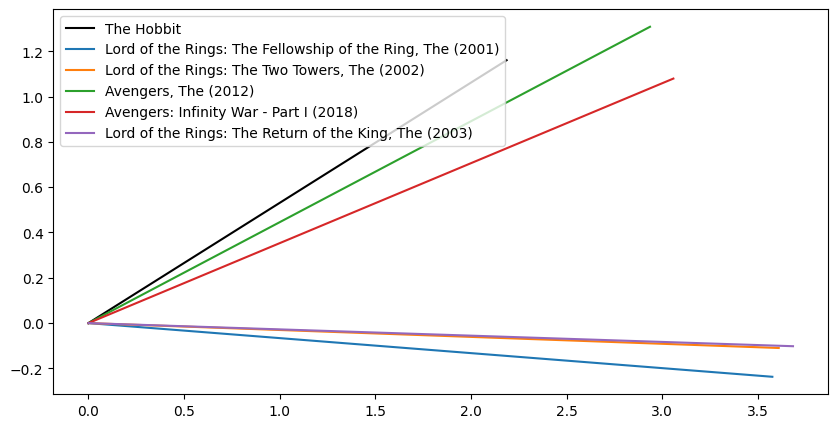

In [41]:
indices_of_top_movies = np.argsort(movie_scores)[-5:]
selected_v = v[indices_of_top_movies]

plt.figure(figsize=(10, 5));

the_hobb = v[myMovieId[98809]]
x = [0, the_hobb[0]]
y = [0, the_hobb[1]]
plt.plot(x, y, label="The Hobbit", color='black');

for i in range(len(indices_of_top_movies)):
    l = selected_v[i]
    movie_index = np.where(myMovieId == indices_of_top_movies[i])[0][0]
    x = [0, l[0]]
    y = [0, l[1]]
    plt.plot(x, y, label = movies[movies['movieId'] == movie_index]['title'].item());

plt.legend();

### Increasing $k$

In [42]:
N = len(ratings)
mid_rank = (min(ratings.rating) + max(ratings.rating)) / 2

# Initialize the regularizers and hyperparameters
k = 3
l = 0.01
tau = 0.1
alpha = 0.01

# User and Item matrices
v = np.random.normal(0, mid_rank / np.sqrt(N), (myMovieId[-1] + 1, k))
u = np.random.normal(0, mid_rank / np.sqrt(N), (myUserId[-1] + 1, k))
# Initialize user and item bias
bm = np.zeros(len(u))
bn = np.zeros(len(v))


rmse = []
loss = []

for z in range(20):

    u = trait_vector_update(l, tau, alpha, k, u, v, bm, bn, user_indices, all_users_movieIds, all_users_ratings)
    v = trait_vector_update(l, tau, alpha, k, v, u, bn, bm, movie_indices, all_movies_userIds, all_movies_ratings)
    print("iteration:", z+1)
    
    loss_val, rmse_val = calc_loss(user_indices, all_users_movieIds, all_users_ratings, u, v, bm, bn, N, l, tau, alpha)
    loss.append(loss_val)
    rmse.append(rmse_val)
    
    print("RMSE:", rmse[-1], "\t", "Loss:", loss[-1])

iteration: 1
RMSE: 0.8656462082346816 	 Loss: -1725802703.7804856
iteration: 2
RMSE: 0.8220360348289648 	 Loss: -1663222956.044765
iteration: 3
RMSE: 0.797327283533982 	 Loss: -1617438531.1581202
iteration: 4
RMSE: 0.7901295748892535 	 Loss: -1574397507.6063633
iteration: 5
RMSE: 0.7871587269050655 	 Loss: -1536181273.8655965
iteration: 6
RMSE: 0.7856164719880312 	 Loss: -1501619993.5094023
iteration: 7
RMSE: 0.7846960622471957 	 Loss: -1470001292.0505693
iteration: 8
RMSE: 0.7840850919814286 	 Loss: -1440737790.6557276
iteration: 9
RMSE: 0.783640458437122 	 Loss: -1413387048.0391974
iteration: 10
RMSE: 0.7832904894987296 	 Loss: -1387628077.825656
iteration: 11
RMSE: 0.7829979543034431 	 Loss: -1363228868.237178
iteration: 12
RMSE: 0.7827435930072546 	 Loss: -1340016892.3114254
iteration: 13
RMSE: 0.7825177631718442 	 Loss: -1317855916.112187
iteration: 14
RMSE: 0.7823157951831802 	 Loss: -1296630805.215988
iteration: 15
RMSE: 0.782135330702396 	 Loss: -1276239978.0906343
iteration: 1

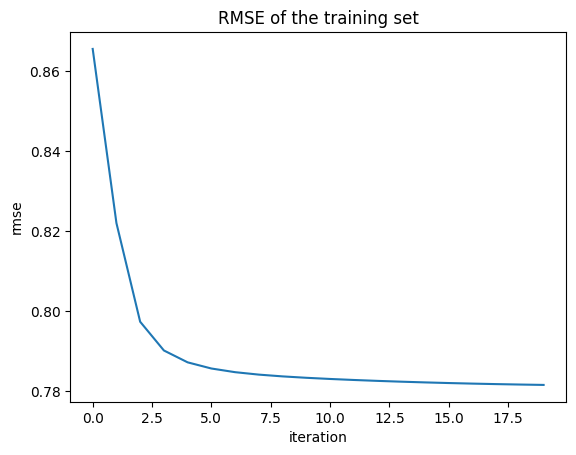

In [43]:
plt.plot(rmse, label='RMSE');
plt.title("RMSE of the training set");
plt.xlabel("iteration");
plt.ylabel("rmse");

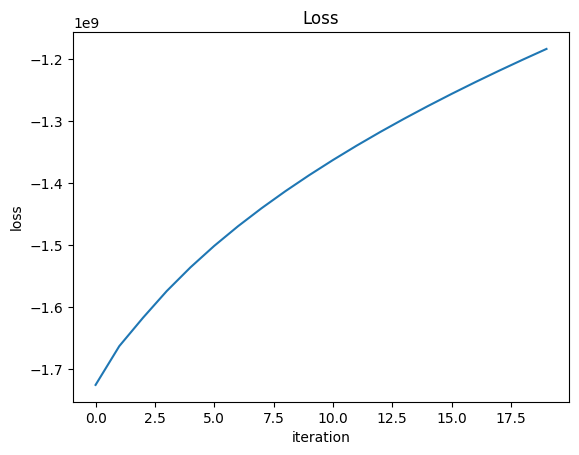

In [44]:
plt.plot(loss, label='Loss');
plt.title("Loss");
plt.xlabel("iteration");
plt.ylabel("loss");

In [45]:
mat1 = np.linalg.inv(l * np.outer(v[myMovieId[98809]], v[myMovieId[98809]]) + tau * np.eye(k))
mat2 = (l * ((5.0 - bn[myMovieId[98809]]) * v[myMovieId[98809]])).reshape(k, 1)

dummy_u = (mat1 @ mat2).reshape(1, k)
movie_scores = (v * dummy_u).sum(axis=1) + 0.05 * bn

In [46]:
top10 = []
for i in np.argsort(movie_scores)[-10:]: 
    top10.append(np.where(myMovieId == i)[0][0])
    
for i in top10:
    print(movies[movies['movieId'] == i])
    print()

       movieId                              title                  genres
25071   122920  Captain America: Civil War (2016)  Action|Sci-Fi|Thriller

       movieId            title                   genres
12324    59315  Iron Man (2008)  Action|Adventure|Sci-Fi

       movieId                           title                   genres
25058   122892  Avengers: Age of Ultron (2015)  Action|Adventure|Sci-Fi

       movieId                                       title  \
21348   110102  Captain America: The Winter Soldier (2014)   

                             genres  
21348  Action|Adventure|Sci-Fi|IMAX  

     movieId              title            genres
108      110  Braveheart (1995)  Action|Drama|War

      movieId                                              title  \
4887     4993  Lord of the Rings: The Fellowship of the Ring,...   

                 genres  
4887  Adventure|Fantasy  

       movieId                                   title  \
25067   122912  Avengers: Infinity War -

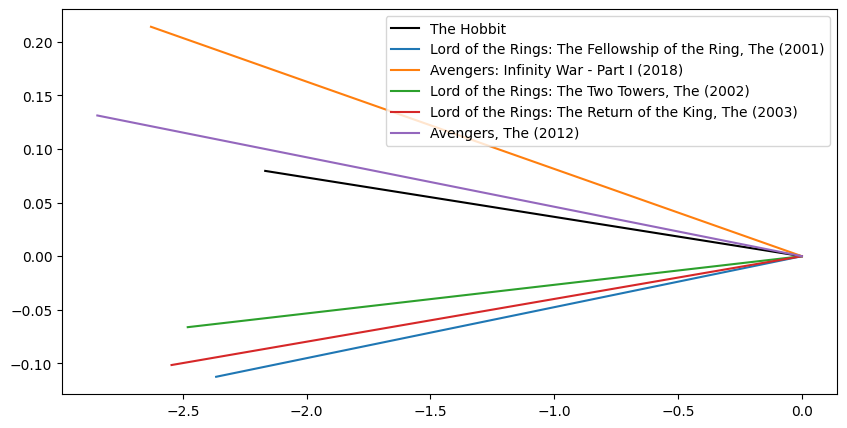

In [47]:
indices_of_top_movies = np.argsort(movie_scores)[-5:]
selected_v = v[indices_of_top_movies]

plt.figure(figsize=(10, 5));

the_hobb = v[myMovieId[98809]]
x = [0, the_hobb[0]]
y = [0, the_hobb[1]]
plt.plot(x, y, label="The Hobbit", color='black');

for i in range(len(indices_of_top_movies)):
    l = selected_v[i]
    movie_index = np.where(myMovieId == indices_of_top_movies[i])[0][0]
    x = [0, l[0]]
    y = [0, l[1]]
    plt.plot(x, y, label = movies[movies['movieId'] == movie_index]['title'].item());

plt.legend();